In [30]:
%pwd

'/Users/sebbyzhao/Research/RecSys/recsys'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import os
import seaborn as sns
import implicit
import pandas as pd
from scipy import sparse
from numpy.linalg import svd
import numpy as np
from als import ALSModel
from utils import apk, validation, train, batch_mapk

/Users/sebbyzhao/Library/Caches/pypoetry/virtualenvs/recsys-HtsDc_SN-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
DATA_DIR = '../data/ml-100k/'

In [5]:
training_data = pd.read_csv(os.path.join(DATA_DIR, 'ua.base'), sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
training_data['user_id'] = training_data['user_id'] - 1
training_data['item_id'] = training_data['item_id'] - 1
training_data.head()

,user_id,item_id,rating,timestamp
0,0,0,5,874965758
1,0,1,3,876893171
2,0,2,4,878542960
3,0,3,3,876893119
4,0,4,3,889751712


In [6]:
test_data = pd.read_csv(os.path.join(DATA_DIR, 'ua.test'), sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
test_data['user_id'] = test_data['user_id'] - 1
test_data['item_id'] = test_data['item_id'] - 1
test_data.head()

,user_id,item_id,rating,timestamp
0,0,19,4,887431883
1,0,32,4,878542699
2,0,60,4,878542420
3,0,116,3,874965739
4,0,154,2,878542201


In [7]:
guarantee_items = pd.concat([pd.DataFrame([[-1, i, -1, -1]], columns=['user_id', 'item_id', 'rating', 'timestamp']) for i in np.unique(np.append(training_data['item_id'].unique(), test_data['item_id'].unique()))],ignore_index=True)
guarantee_items

,user_id,item_id,rating,timestamp
0,-1,0,-1,-1
1,-1,1,-1,-1
2,-1,2,-1,-1
3,-1,3,-1,-1
4,-1,4,-1,-1
...,...,...,...,...
1677,-1,1677,-1,-1
1678,-1,1678,-1,-1
1679,-1,1679,-1,-1
1680,-1,1680,-1,-1


In [8]:
training_data = pd.concat([training_data, guarantee_items], ignore_index=True)
test_data = pd.concat([test_data, guarantee_items], ignore_index=True)

In [37]:
test_rating_matrix = pd.pivot_table(test_data, index='user_id', columns='item_id', values='rating', fill_value=0)
test_rating_matrix = test_rating_matrix.drop(-1)

In [39]:
test_proxy_array = test_rating_matrix.values > 0
test_proxy_array = test_proxy_array.astype(int)
test_proxy_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [40]:
test_rating_array = test_rating_matrix.values > 3
test_true_array = test_rating_array.astype(int)
test_true_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
rating_matrix = pd.pivot_table(training_data, values='rating', index='user_id', columns='item_id', fill_value=0)
rating_matrix = rating_matrix.drop(-1)

In [41]:
rating_proxy = rating_matrix.copy().applymap(lambda x: 1 if x > 0 else 0)
rating_proxy.head()

item_id,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
user_id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
rating_proxy_array = rating_proxy.values

## Verify callback and recommender produces same results ##

In [43]:
watch_matrix_csr = sparse.csr_matrix(rating_proxy_array)

In [44]:
proxy_prefs = [list(np.where(row == 1)[0]) for row in test_proxy_array]

In [45]:
proxy_prefs

[[19, 32, 60, 116, 154, 159, 170, 188, 201, 264],
 [12, 49, 250, 279, 280, 289, 291, 296, 311, 313],
 [244, 293, 322, 327, 330, 331, 333, 334, 336, 342],
 [49, 259, 263, 287, 293, 302, 353, 355, 356, 360],
 [0, 1, 16, 97, 109, 224, 362, 423, 438, 453],
 [13, 22, 68, 85, 97, 257, 300, 462, 491, 516],
 [31, 162, 381, 429, 454, 478, 491, 496, 647, 660],
 [21, 49, 78, 88, 181, 293, 337, 384, 456, 549],
 [5, 285, 297, 339, 478, 486, 506, 520, 526, 690],
 [6, 15, 99, 174, 284, 460, 485, 487, 503, 610],
 [37, 109, 110, 226, 424, 557, 722, 724, 731, 739],
 [81, 95, 96, 131, 142, 171, 203, 299, 470, 734],
 [55, 97, 185, 197, 214, 271, 343, 359, 525, 835],
 [21, 97, 110, 173, 212, 268, 356, 473, 529, 708],
 [24, 126, 221, 330, 404, 472, 677, 684, 748, 931],
 [7, 54, 63, 88, 177, 193, 196, 208, 704, 943],
 [0, 8, 12, 116, 124, 150, 236, 244, 507, 743],
 [25, 85, 112, 181, 201, 407, 442, 495, 728, 949],
 [3, 152, 200, 257, 309, 312, 381, 434, 654, 691],
 [10, 117, 171, 175, 185, 193, 207, 287, 404

In [46]:
true_prefs = [list(np.where(row == 1)[0]) for row in test_true_array]

In [47]:
proxy_losses, true_losses = [], []

In [48]:
def validation_hook(solver, epoch, elapsed_time, progress):
    # print(solver.user_factors.shape)
    # print(solver.item_factors.shape)
    recommendations = solver.recommend(np.arange(solver.user_factors.shape[0]), watch_matrix_csr, filter_already_liked_items=True, N=10)[0]
    #FIXME: This should actually be the indices of the items
    global proxy_prefs
    global true_prefs
    print(batch_mapk(recommendations, proxy_prefs, true_prefs))

    # Calculate validation loss
    

In [49]:
model = implicit.als.AlternatingLeastSquares(factors=100, calculate_training_loss=True, iterations=20)
model.fit(watch_matrix_csr, callback=validation_hook)

  5%|▌         | 1/20 [00:01<00:14,  1.30it/s, loss=0.0278]

(0.09746907034287737, 0.09923775929011885)


 10%|█         | 2/20 [00:02<00:19,  1.08s/it, loss=0.022] 

(0.1136535289265937, 0.11432983922723491)


 15%|█▌        | 3/20 [00:03<00:19,  1.16s/it, loss=0.0201]

(0.11395992189735567, 0.11727335150705348)


 20%|██        | 4/20 [00:04<00:19,  1.20s/it, loss=0.0194]

(0.11149207190829667, 0.11472932091417927)


 25%|██▌       | 5/20 [00:06<00:18,  1.22s/it, loss=0.019] 

(0.11154904980726844, 0.11368637912138282)


 30%|███       | 6/20 [00:07<00:17,  1.25s/it, loss=0.0188]

(0.11019113265666833, 0.11313862828623858)


 35%|███▌      | 7/20 [00:08<00:16,  1.26s/it, loss=0.0186]

(0.1097388442828529, 0.11176257148120636)


 40%|████      | 8/20 [00:09<00:15,  1.26s/it, loss=0.0185]

(0.10985431500277731, 0.11138511811582189)


 45%|████▌     | 9/20 [00:11<00:13,  1.26s/it, loss=0.0184]

(0.10995779259034826, 0.1114236015092578)


 50%|█████     | 10/20 [00:12<00:12,  1.27s/it, loss=0.0184]

(0.11017783500816382, 0.11135717221376602)


 55%|█████▌    | 11/20 [00:14<00:12,  1.35s/it, loss=0.0183]

(0.10972462084869293, 0.11089868338050449)


 60%|██████    | 12/20 [00:15<00:10,  1.34s/it, loss=0.0183]

(0.11028413203386696, 0.11120017957302725)


 65%|██████▌   | 13/20 [00:16<00:09,  1.34s/it, loss=0.0183]

(0.10972891312764045, 0.110456541911372)


 70%|███████   | 14/20 [00:17<00:07,  1.31s/it, loss=0.0182]

(0.10935569526502702, 0.1106488256215255)


 75%|███████▌  | 15/20 [00:19<00:06,  1.33s/it, loss=0.0182]

(0.10958415391607322, 0.11103961220401913)


 80%|████████  | 16/20 [00:20<00:05,  1.33s/it, loss=0.0182]

(0.10975719167129545, 0.11084472447122674)


 85%|████████▌ | 17/20 [00:22<00:04,  1.34s/it, loss=0.0182]

(0.10999440320490152, 0.1111804010909575)


 90%|█████████ | 18/20 [00:23<00:02,  1.39s/it, loss=0.0181]

(0.110263596424784, 0.11172822039149102)


 95%|█████████▌| 19/20 [00:24<00:01,  1.40s/it, loss=0.0181]

(0.11010596037637385, 0.11169747525694218)


100%|██████████| 20/20 [00:26<00:00,  1.34s/it, loss=0.0181]

(0.1101960561531081, 0.1116443380993259)


[0.027762590143797297,
 0.02202918507161188,
 0.020148951936662173,
 0.01940257462306702,
 0.019012163496120785,
 0.018780353674753714,
 0.018629144378875487,
 0.018522958300127745,
 0.018444023518700912,
 0.018382737350278188,
 0.018333520709107428,
 0.018292868562475827,
 0.018258543729933723,
 0.01822900147646279,
 0.018203193789406824,
 0.018180315516597854,
 0.018159820269062855,
 0.01814128195798567,
 0.018124399612940708,
 0.01810891791589639]

## Running native optimization ##

In [20]:
model = ALSModel(rating_proxy_array)

In [21]:
model, training_losses, proxy_losses, true_losses = train(model, rating_proxy_array, test_proxy_array, test_true_array, num_epochs=10)

===
Epoch:  0
Training Error:  0.9361074915938322
Validation Proxy MAP@K:  0.10371952347323109
Validation True MAP@K:  0.10724098672150907
===
Epoch:  1
Training Error:  0.30890280192148206
Validation Proxy MAP@K:  0.1184892890772128
Validation True MAP@K:  0.1224458058293939
===
Epoch:  2
Training Error:  0.255100868313772
Validation Proxy MAP@K:  0.12002236346516007
Validation True MAP@K:  0.12446500867688569
===
Epoch:  3
Training Error:  0.24097671851487576
Validation Proxy MAP@K:  0.12184755010761367
Validation True MAP@K:  0.12613920356278105
===
Epoch:  4
Training Error:  0.23414793648856788
Validation Proxy MAP@K:  0.1214898607748184
Validation True MAP@K:  0.12549471126335027
===
Epoch:  5
Training Error:  0.230236089751351
Validation Proxy MAP@K:  0.12082416935700835
Validation True MAP@K:  0.1251001653505878
===
Epoch:  6
Training Error:  0.22779483183455945
Validation Proxy MAP@K:  0.12071436978746301
Validation True MAP@K:  0.12476967152209283
===
Epoch:  7
Training Error:

In [ ]:
training_losses, proxy_losses, true_losses 

([0.9385453692981001,
  0.30827471885695396,
  0.25477400700040265,
  0.2410100659226097,
  0.23436625917864157,
  0.23056018665256892,
  0.22818435473066803,
  0.2266153737456271,
  0.22553423708030002,
  0.22476313822985255,
  0.22419717950493182,
  0.22377159829734003,
  0.22344483427120235,
  0.22318932911347192,
  0.2229862275181938,
  0.22282239789659986,
  0.22268845212435665,
  0.22257754514528777,
  0.2224846839151346,
  0.2224061025905471,
  0.22233898170743335,
  0.22228114463102183,
  0.22223094515662853,
  0.22218707497585943,
  0.22214851764777147,
  0.22211444670533628,
  0.2220842195532779,
  0.22205731758748462,
  0.2220332842512831,
  0.22201174837214507,
  0.22199244173031385,
  0.22197505691756964,
  0.2219593730309447,
  0.2219452278455124,
  0.22193242092919643,
  0.2219208107887865,
  0.22191028750313865,
  0.22190070689127855,
  0.22189198614135855,
  0.2218840157899667,
  0.22187672893723034,
  0.22187003171302966,
  0.2218638944637826,
  0.2218582429041444,
  

## Graphing ##

In [60]:
baseline_recs = test_data.groupby('item_id').count().sort_values('user_id', ascending=False).index.values[:10]
baseline_recs

array([257, 287,  49, 293, 299, 285, 312, 180,  99, 747])

In [65]:
# Proxy objective baseline
proxy_obj_baseline = np.mean([apk(baseline_recs, np.where(test_proxy_array[i, :])[0], np.where(test_true_array[i, :])[0])[0] for i in range(len(test_rating_array))])
print("Proxy objective baseline: " + str(proxy_obj_baseline))

Proxy objective baseline: 0.01173605850965342


In [ ]:
# Figure out why there's a diff between the two options.
# Not all item ids are inputted.

In [123]:
# True objective baseline
true_obj_baseline = np.mean([apk(baseline_recs, np.where(test_proxy_array[i, :])[0], np.where(test_rating_array[i, :])[0])[1] for i in range(len(test_rating_array))])
print("True objective baseline: " + str(true_obj_baseline))

True objective baseline: 0.01259633030188628


In [210]:
data = np.hstack([np.array(training_losses).reshape(-1, 1), np.array(proxy_losses).reshape(-1, 1), np.array(true_losses).reshape(-1, 1), np.full((len(training_losses), 1), proxy_obj_baseline), np.full((len(training_losses), 1), true_obj_baseline)])
data = pd.DataFrame(data)
data = data.rename(mapper={0: 'Training Loss', 1: 'Validation Proxy MAP@K', 2: 'Validation True MAP@K', 3: 'Proxy MAP@K Baseline', 4: 'True MAP@K Baseline'}, axis=1)
data

,Training Loss,Validation Proxy MAP@K,Validation True MAP@K,Proxy MAP@K Baseline,True MAP@K Baseline
0,0.938545,0.107595,0.015703,0.035147,0.012596
1,0.308275,0.118791,0.014742,0.035147,0.012596
2,0.254774,0.116997,0.013883,0.035147,0.012596
3,0.241010,0.118031,0.014280,0.035147,0.012596
4,0.234366,0.119711,0.014330,0.035147,0.012596
...,...,...,...,...,...
95,0.221764,0.121545,0.013387,0.035147,0.012596
96,0.221764,0.121633,0.013453,0.035147,0.012596
97,0.221763,0.121747,0.013456,0.035147,0.012596
98,0.221763,0.121617,0.013443,0.035147,0.012596


<Axes: >

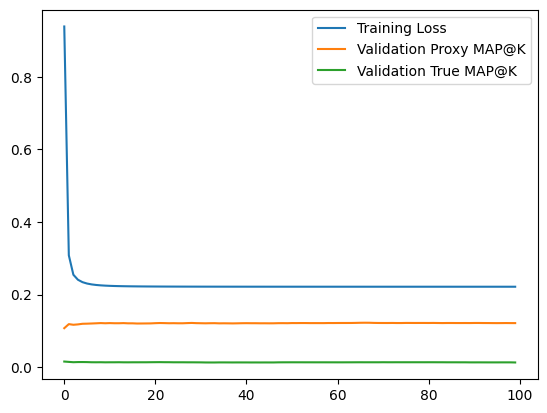

In [211]:
sns.lineplot(data=data[['Training Loss', 'Validation Proxy MAP@K', 'Validation True MAP@K']], dashes=False)

<Axes: >

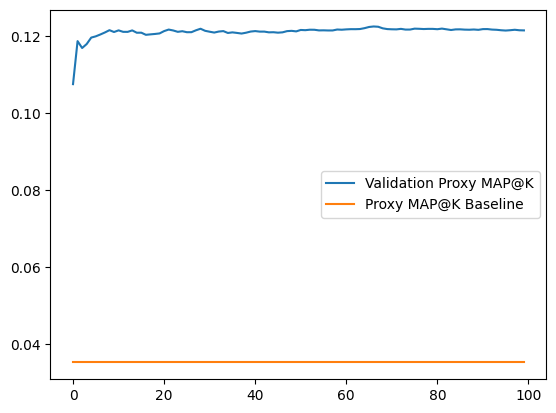

In [212]:
sns.lineplot(data=data[['Validation Proxy MAP@K', 'Proxy MAP@K Baseline']].iloc[:100], dashes=False)

<Axes: >

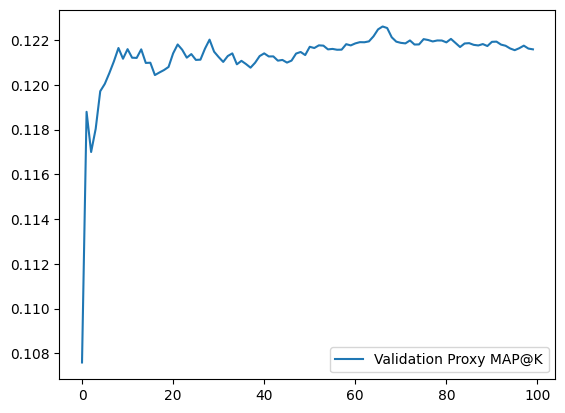

In [213]:
sns.lineplot(data=data[['Validation Proxy MAP@K']].iloc[:100], dashes=False)

<Axes: >

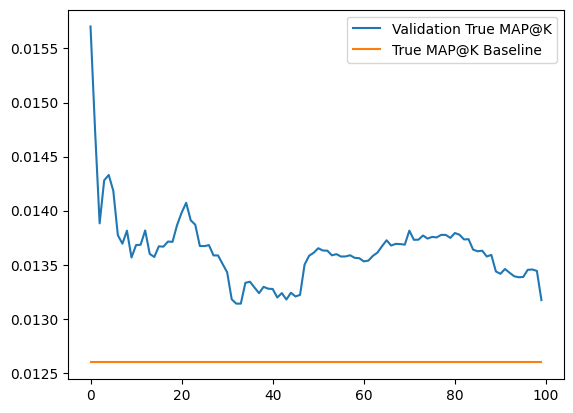

In [214]:
sns.lineplot(data=data[['Validation True MAP@K', 'True MAP@K Baseline']].iloc[:100], dashes=False)

<Axes: ylabel='Validation True MAP@K'>

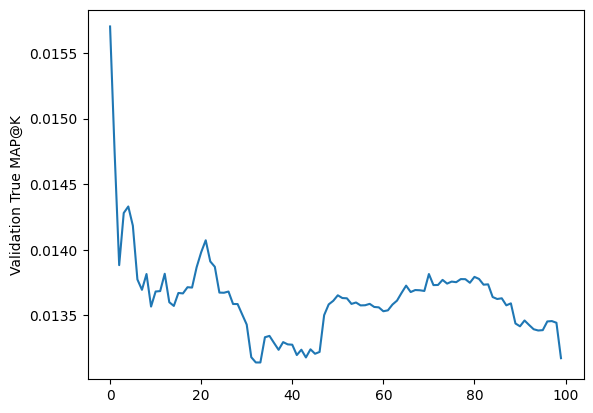

In [215]:
sns.lineplot(data=data['Validation True MAP@K'].iloc[:100], dashes=False)

## Simulated Data ##

In [235]:
def simulated_data(n, users, items, corr, sd=1):
    """
    Generates fake data 

    Parameters:
    n: int = number of data points to generate for each user
    users: int = number of users
    items: int = number of items
    corr: float = correlation between proxy objective and true objective
    sd: float = standard deviation of noise

    Returns:
    proxy_data: pd.DataFrame = proxy data
    true_data: pd.DataFrame = underlying true distribution
    """
    true_data = pd.DataFrame()
    proxy_data = pd.DataFrame()

    for i in range(users):
        # Generate true data
        sampled_items = np.random.choice(items, size=n, replace=False)
        true_data_i = pd.DataFrame()
        true_data_i['user_id'] = [i] * n
        true_data_i['item_id'] = sampled_items
        # True ratings, drawn uniformly from 0 to 5
        true_data_i['rating'] = np.random.Generator.uniform(0, 5, size=n)
        true_data = pd.concat([true_data, true_data_i], axis=0)

        # Generate proxy data
        proxy_data_i = pd.DataFrame()
        proxy_data_i['user_id'] = [i] * n
        proxy_data_i['item_id'] = sampled_items
        # Proxy ratings, drawn from normal distribution with mean true rating and standard deviation sd
        proxy_data_i['rating'] = true_data_i['rating'] * corr + np.random.normal(size=n, loc=0, scale=sd)
        proxy_data = pd.concat([proxy_data, proxy_data_i], axis=0)
    
    return proxy_data, true_data

    
    

In [ ]:
def simulated_data_indicators(n, users, items, corr):
    """
    Generates fake data 

    Parameters:
    n: int = number of data points to generate for each user
    users: int = number of users
    items: int = number of items
    corr: float = correlation between proxy objective and true objective
    sd: float = standard deviation of noise

    Returns:
    proxy_data: pd.DataFrame = proxy data
    true_data: pd.DataFrame = underlying true distribution
    """
    true_data = pd.DataFrame()
    proxy_data = pd.DataFrame()

    for i in range(users):
        # Generate true data
        sampled_items = np.random.choice(items, size=n, replace=False)
        true_data_i = pd.DataFrame()
        true_data_i['user_id'] = [i] * n
        true_data_i['item_id'] = sampled_items
        # True ratings, drawn uniformly from 0 to 5
        true_data_i['rating'] = np.random.randint(0, 2, size=n)
        true_data = pd.concat([true_data, true_data_i], axis=0)

        # Generate proxy data
        proxy_data_i = pd.DataFrame()
        proxy_data_i['user_id'] = [i] * n
        proxy_data_i['item_id'] = sampled_items
        # Proxy ratings, drawn from normal distribution with mean true rating and standard deviation sd
        proxy_data_i['rating'] = 
        proxy_data = pd.concat([proxy_data, proxy_data_i], axis=0)
    
    return proxy_data, true_data

    
    

In [239]:
proxy_data, true_data = simulated_data(10, 1000, 2000, 1, sd=1)

In [242]:
# Split into train and validation (shouldn't be too hard)
# Find some way to turn this into a proxy objective -> with implicit dataset I could just use the ratings?
proxy_data

,user_id,item_id,rating
0,0,1862,2.390586
1,0,1511,6.406821
2,0,1051,2.068357
3,0,1262,2.110399
4,0,1488,0.739352
...,...,...,...
5,999,486,5.331730
6,999,1527,-0.868833
7,999,506,4.422085
8,999,1703,3.151032


In [ ]:
proxy_data, true_data = simulated_data(10, 1000, 2000, 1, sd=1)

In [240]:
proxy_data, true_data = simulated_data(10, 1000, 2000, 0.5, sd=1)